# Regressão Linear e Otimização

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
root_mean_squared_error = lambda a, b: ((a-b)**2).mean()**0.5
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from ipywidgets import interact, FloatLogSlider

In [2]:
def plot_contour(X, y, w, n_levels=15, gap=20):
    w = w.reshape(-1, 2)
    a0 = [w[:,0].min(), w[:,0].max()]
    a1 = [w[:,1].min(), w[:,1].max()]
    width0 = a0[1] - a0[0]
    width1 = a1[1] - a1[0]
    width = max(width0, width1)
    if width == 0:
        width = 2*gap
    if width0 < width:
        a0[0] -= (width - width0)/2
        a0[1] += (width - width0)/2
    if width1 < width:
        a1[0] -= (width - width1)/2
        a1[1] += (width - width1)/2
    w0, w1 = np.meshgrid(np.linspace(*a0, 100), np.linspace(*a1, 100))
    Z = np.log10(np.mean((w0 + X.reshape(-1, 1, 1)*w1 - y.reshape(-1, 1, 1))**2, axis=0))
    cs = plt.contour(w0, w1, Z, levels=np.linspace(Z.min(), Z.max(), n_levels), cmap='Blues_r');
    plt.colorbar();
    plt.title('log10(MSE)')
    plt.xlabel('w0')
    plt.ylabel('w1')
    plt.plot(w[:,0], w[:,1], 'r.-')
    return

## Método do gradiente

In [3]:
def gen_data(n_samples, random_state):
    rng = np.random.RandomState(random_state)
    x = rng.uniform(2, 12, size=n_samples)
    y = 70 + 8*x + 10*rng.standard_normal(size=n_samples)
    X = x.reshape(-1, 1)
    return X, y

(100, 1) (100,)


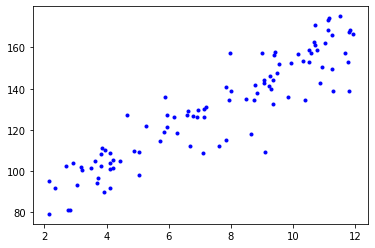

In [4]:
X, y = gen_data(n_samples=100, random_state=27)
print(X.shape, y.shape)
plt.plot(X, y, 'b.');

### Solução analítica

In [5]:
model = LinearRegression()
model.fit(X, y)
w_opt = np.r_[model.intercept_, model.coef_]
mse_opt = mean_squared_error(y, model.predict(X))
print('w (opt) =', w_opt)
print('MSE (opt):', mse_opt)

w (opt) = [72.72933286  7.68114992]
MSE (opt): 99.54452956702795


### Método do gradiente

In [6]:
from sklearn.base import BaseEstimator
class LinReg(BaseEstimator):
    '''Linear regression using gradient descent'''
    def __init__(self, lr, max_iter=1000, tol=1e-5):
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
        return
    
    def _add_ones_column(self, X):
        X = np.c_[np.ones(X.shape[0]), X]
        return X
        
    def fit(self, X, y):
        X = self._add_ones_column(X)
        self.hessian = (2/X.shape[1])*X.T@X  # just for illustration!
        w = np.zeros(X.shape[1])
        weight_history = [w]
        cost_history = [np.mean(y**2)]
        for t in range(self.max_iter):
            grad = (2/X.shape[1])*X.T@(X@w - y)
            w = w - self.lr*grad  # don't change inplace (w -= ...) if saving weight history!
            weight_history.append(w)
            cost = np.mean((X@w - y)**2)
            cost_history.append(cost)
            if np.linalg.norm(grad) < self.tol or cost >= 1e50:
                break
        self.w = w
        self.intercept_ = w[0]
        self.coef_ = w[1:]
        self.weight_history = np.array(weight_history)
        self.cost_history = np.array(cost_history)
        self.n_iter = len(cost_history) - 1
        return self

    def predict(self, X):
        X = self._add_ones_column(X)
        y_pred = X @ self.w
        return y_pred

w = [71.51552364  7.82213436] (MAPE from w_opt: 1.75%)
MSE: 99.7466
Iterations: 1000


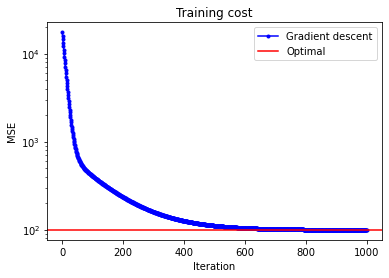

In [7]:
model = LinReg(lr=3e-4, max_iter=1000)
model.fit(X, y)
print(f'w = {model.w} (MAPE from w_opt: {mean_absolute_percentage_error(w_opt, model.w):.2%})')
print(f'MSE: {mean_squared_error(y, model.predict(X)):g}')
print('Iterations:', model.n_iter)
plt.plot(model.cost_history, 'b.-', label='Gradient descent')
plt.axhline(mse_opt, color='r', label='Optimal')
plt.title('Training cost')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
plt.yscale('log')

In [8]:
@interact(lr=FloatLogSlider(1e-4, min=-6, max=0, step=0.1, readout_format='.2e'), contour=False, zoom=False)
def _(lr, contour, zoom):
    model = LinReg(lr)
    model.fit(X, y)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(model.cost_history, 'b.-', label='Gradient descent')
    plt.axhline(mse_opt, color='r', label='Optimal')
    plt.title('Training cost')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.legend()
    plt.yscale('log')
    if contour:
        plt.subplot(1,2,2)
        wh = model.weight_history
        plot_contour(X, y, wh)
        if zoom:
            plt.axis([0, 30, 0, 30])
    plt.show()
    print(f'w = {model.w} (MAPE from w_opt: {mean_absolute_percentage_error(w_opt, model.w):.2%})')
    print(f'MSE: {mean_squared_error(y, model.predict(X)):g}')
    print('Iterations:', model.n_iter)

interactive(children=(FloatLogSlider(value=0.0001, description='lr', max=0.0, min=-6.0, readout_format='.2e'),…

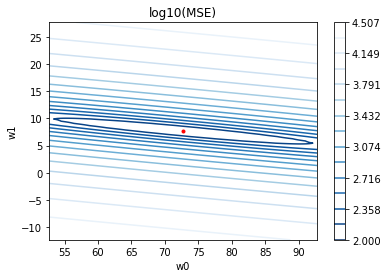

In [9]:
plot_contour(X, y, w_opt)

In [10]:
print('Condition number: %f' % np.linalg.cond(model.hessian))

Condition number: 481.118846


- Voltar ao `interact` e selecionar *contour*

## Escalonamento de atributos

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Solução analítica

In [12]:
model = LinearRegression()
model.fit(X_scaled, y)
w_opt = np.r_[model.intercept_, model.coef_]
mse_opt = mean_squared_error(y, model.predict(X_scaled))
print('w (opt) =', w_opt)
print('MSE (opt):', mse_opt)

w (opt) = [129.91290855  22.79543241]
MSE (opt): 99.54452956702794


### Método do gradiente

w = [129.91290846  22.7954324 ] (MAPE from w_opt: 0.00%)
MSE: 99.5445
Iterations: 691


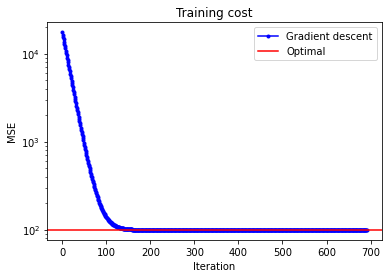

In [13]:
model = LinReg(lr=3e-4, max_iter=1000)
model.fit(X_scaled, y)
print(f'w = {model.w} (MAPE from w_opt: {mean_absolute_percentage_error(w_opt, model.w):.2%})')
print(f'MSE: {mean_squared_error(y, model.predict(X_scaled)):g}')
print('Iterations:', model.n_iter)
plt.plot(model.cost_history, 'b.-', label='Gradient descent')
plt.axhline(mse_opt, color='r', label='Optimal')
plt.title('Training cost')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
plt.yscale('log')

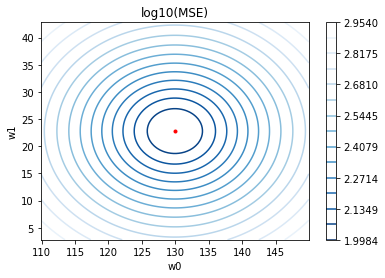

In [14]:
plot_contour(X_scaled, y, w_opt)

In [15]:
print('Condition number: %f' % np.linalg.cond(model.hessian))

Condition number: 1.000000


In [16]:
@interact(lr=FloatLogSlider(1e-4, min=-6, max=0, step=0.1, readout_format='.2e'))
def _(lr):
    model = LinReg(lr)
    model.fit(X_scaled, y)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(model.cost_history, 'b.-', label='Gradient descent')
    plt.axhline(mse_opt, color='r', label='Optimal')
    plt.title('Training cost')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.legend()
    plt.yscale('log')
    plt.subplot(1,2,2)
    wh = model.weight_history
    plot_contour(X_scaled, y, wh)
    plt.show()
    print(f'w = {model.w} (MAPE from w_opt: {mean_absolute_percentage_error(w_opt, model.w):.2%})')
    print(f'MSE: {mean_squared_error(y, model.predict(X_scaled)):g}')
    print('Iterations:', model.n_iter)

interactive(children=(FloatLogSlider(value=0.0001, description='lr', max=0.0, min=-6.0, readout_format='.2e'),…